## Business problem

#### Stakeholder: NASA

- Want a prediction of whether a star is variable that can be used in absence of a true classification.

#### True business problem:  

- Predict whether a star is variable or not using other information about the star.

#### Deliverables: Inference or Prediction?

- Prediction
    - If a star isn't classified as variable or not, then our prediction can be used in absence of a true classification

#### Context:

- **False negative** Predicts star is not variable, star is variable
    - **Outcome**: A variable star is overlooked.
- **False positive** Predicts star is variable, star is not variable
    - **Outcome**: Resources are put into looking at a star which is not variable.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, plot_confusion_matrix, confusion_matrix, plot_roc_curve, precision_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("../../data/UsableData.csv")
holdoutdf = pd.read_csv("../../data/UntestableData.csv")
df = df.drop(columns=['Unnamed: 0'])
df['HvarType'] = df['HvarType'].mask(df['HvarType'] != 'C', other='V')

df = df.drop(columns=['Catalog', 'VarFlag', '---', 'Period', 'moreVar', 'morePhoto', 'Source'])
holdoutdf = holdoutdf.drop(columns=['Unnamed: 0', 'Catalog', 'VarFlag', '---', 'Period', 'moreVar', 'morePhoto', 'Source'])

mask = {
    'C': 0,
    'V': 1
}
df['Target'] = df['HvarType'].map(mask)

x = df.drop(columns=['HvarType','Target',
                     'HIP'])
y = df['Target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=42)

In [3]:
def displayMetrics(fitModel, xtr, xte, ytr, yte):
    train_preds = fitModel.predict(xtr)
    test_preds = fitModel.predict(xte)
    train_probs = fitModel.predict_proba(xtr)[:,1]
    test_probs = fitModel.predict_proba(xte)[:,1]

    train_accuracy = accuracy_score(ytr, train_preds)
    test_accuracy = accuracy_score(yte, test_preds)
    train_recall = recall_score(ytr, train_preds, zero_division=0)
    test_recall = recall_score(yte, test_preds, zero_division=0)
    train_precision = precision_score(ytr, train_preds, zero_division=0)
    test_precision = precision_score(yte, test_preds, zero_division=0)
    train_f1 = f1_score(ytr, train_preds, zero_division=0)
    test_f1 = f1_score(yte, test_preds, zero_division=0)
    train_rocauc = roc_auc_score(ytr, train_probs)
    test_rocauc = roc_auc_score(yte, test_probs)

    print(F'\nTrain Accuracy:\t\t{train_accuracy}')
    print(F'Test Accuracy:\t\t{test_accuracy}')
    print(F"\nTrain Recall:\t\t{train_recall}")
    print(F'Test Recall:\t\t{test_recall}')
    print(F"\nTrain Precision:\t{train_precision}")
    print(F'Test Precision:\t\t{test_precision}')
    print(F"\nTrain f1:\t\t{train_f1}")
    print(F'Test f1:\t\t{test_f1}')
    print(F"\nTrain ROC-AUC:\t\t{train_rocauc}")
    print(F'Test ROC-AUC:\t\t{test_rocauc}')
    
    plot_confusion_matrix(fitModel, xte, yte)

In [4]:
pd.set_option('display.max_rows', None)

In [5]:
for col in holdoutdf.columns:
    print(f"df {col} nulls: {df[col].isna().sum()}, {round((df[col].isna().sum() / len(df)), 4)}")
    print(f"Holdoutdf {col} nulls: {holdoutdf[col].isna().sum()}, {round((holdoutdf[col].isna().sum() / len(holdoutdf)), 4)}")
    print(f"Difference: {df[col].isna().sum() - holdoutdf[col].isna().sum()}\n")

df HIP nulls: 0, 0.0
Holdoutdf HIP nulls: 0, 0.0
Difference: 0

df Proxy nulls: 61801, 0.8629
Holdoutdf Proxy nulls: 45492, 0.9763
Difference: 16309

df RAhms nulls: 0, 0.0
Holdoutdf RAhms nulls: 0, 0.0
Difference: 0

df DEdms nulls: 0, 0.0
Holdoutdf DEdms nulls: 0, 0.0
Difference: 0

df Vmag nulls: 0, 0.0
Holdoutdf Vmag nulls: 1, 0.0
Difference: -1

df r_Vmag nulls: 0, 0.0
Holdoutdf r_Vmag nulls: 1, 0.0
Difference: -1

df RAdeg nulls: 213, 0.003
Holdoutdf RAdeg nulls: 50, 0.0011
Difference: 163

df DEdeg nulls: 213, 0.003
Holdoutdf DEdeg nulls: 50, 0.0011
Difference: 163

df AstroRef nulls: 59269, 0.8275
Holdoutdf AstroRef nulls: 45215, 0.9704
Difference: 14054

df Plx nulls: 213, 0.003
Holdoutdf Plx nulls: 50, 0.0011
Difference: 163

df pmRA nulls: 213, 0.003
Holdoutdf pmRA nulls: 50, 0.0011
Difference: 163

df pmDE nulls: 213, 0.003
Holdoutdf pmDE nulls: 50, 0.0011
Difference: 163

df e_RAdeg nulls: 213, 0.003
Holdoutdf e_RAdeg nulls: 50, 0.0011
Difference: 163

df e_DEdeg nulls: 21

In [6]:
y_train.value_counts(normalize=True)

0    0.650421
1    0.349579
Name: Target, dtype: float64

Guessing not variable every time would be correct 65% of the time.

In [7]:
numCols = [col for col in x_train.columns if x_train[col].dtype != 'O']
numCols

['Vmag',
 'RAdeg',
 'DEdeg',
 'Plx',
 'pmRA',
 'pmDE',
 'e_RAdeg',
 'e_DEdeg',
 'e_Plx',
 'e_pmRA',
 'e_pmDE',
 'DE:RA',
 'Plx:RA',
 'Plx:DE',
 'pmRA:RA',
 'pmRA:DE',
 'pmRA:Plx',
 'pmDE:RA',
 'pmDE:DE',
 'pmDE:Plx',
 'pmDE:pmRA',
 'F1',
 'F2',
 'BTmag',
 'e_BTmag',
 'VTmag',
 'e_VTmag',
 'B-V',
 'e_B-V',
 'V-I',
 'e_V-I',
 'Hpmag',
 'e_Hpmag',
 'Hpscat',
 'o_Hpmag',
 'Hpmax',
 'HPmin',
 'Nsys',
 'Ncomp',
 'theta',
 'rho',
 'e_rho',
 'dHp',
 'e_dHp',
 'HD',
 '(V-I)red']

In [8]:
x_train[numCols].isna().sum()

Vmag             0
RAdeg          165
DEdeg          165
Plx            165
pmRA           165
pmDE           165
e_RAdeg        165
e_DEdeg        165
e_Plx          165
e_pmRA         165
e_pmDE         165
DE:RA          165
Plx:RA         165
Plx:DE         165
pmRA:RA        165
pmRA:DE        165
pmRA:Plx       165
pmDE:RA        165
pmDE:DE        165
pmDE:Plx       165
pmDE:pmRA      165
F1             165
F2             858
BTmag         1376
e_BTmag       1376
VTmag         1348
e_VTmag       1348
B-V            689
e_B-V          689
V-I            689
e_V-I          689
Hpmag            1
e_Hpmag          1
Hpscat         707
o_Hpmag        707
Hpmax          707
HPmin          707
Nsys         41951
Ncomp          165
theta        46366
rho          46366
e_rho        46366
dHp          46366
e_dHp        46366
HD            8717
(V-I)red         0
dtype: int64

### Simple Models, model each numeric variable with a logistic regression:

In [9]:
preprocessor = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])

Run a simple model for each numeric column and print metrics for it. If those metrics are all above 0, then add that column to a list to be used later.

In [10]:
len(numCols)

46

In [11]:
used_num_cols = []
for col in numCols:
    lg = Pipeline(steps=[
        ('preprocessor',preprocessor),
        ('model',LogisticRegression(max_iter=5000, random_state=42))
    ])
    lg.fit(x_train[[col]], y_train)
    
    train_preds = lg.predict(x_train[[col]])
    test_preds = lg.predict(x_test[[col]])
    train_probs = lg.predict_proba(x_train[[col]])[:,1]
    test_probs = lg.predict_proba(x_test[[col]])[:,1]
    
    train_accuracy = accuracy_score(y_train, train_preds)
    test_accuracy = accuracy_score(y_test, test_preds)
    train_recall = recall_score(y_train, train_preds, zero_division=0)
    test_recall = recall_score(y_test, test_preds, zero_division=0)
    train_precision = precision_score(y_train, train_preds, zero_division=0)
    test_precision = precision_score(y_test, test_preds, zero_division=0)
    train_f1 = f1_score(y_train, train_preds, zero_division=0)
    test_f1 = f1_score(y_test, test_preds, zero_division=0)
    train_rocauc = roc_auc_score(y_train, train_probs)
    test_rocauc = roc_auc_score(y_test, test_probs)
    
    print(col)
    if (train_accuracy > 0) and (test_accuracy > 0) and (train_recall > 0) and (test_recall > 0) and (train_precision > 0) and (test_precision > 0) and (train_f1 > 0) and (test_f1 > 0) and (train_rocauc > 0) and (test_rocauc > 0):
        used_num_cols.append(col)
        print(f'{col} added to used column list')
    print(F'\nTrain Accuracy:\t\t{train_accuracy}')
    print(F'Test Accuracy:\t\t{test_accuracy}')
    print(F"\nTrain Recall:\t\t{train_recall}")
    print(F'Test Recall:\t\t{test_recall}')
    print(F"\nTrain Precision:\t{train_precision}")
    print(F'Test Precision:\t\t{test_precision}')
    print(F"\nTrain f1:\t\t{train_f1}")
    print(F'Test f1:\t\t{test_f1}')
    print(F"\nTrain ROC-AUC:\t\t{train_rocauc}")
    print(F'Test ROC-AUC:\t\t{test_rocauc}')
    print("\nTrain Matrix:\n")
    print(confusion_matrix(y_train, train_preds))
    print("\nTest Matrix:\n")
    print(confusion_matrix(y_test, test_preds))
    print('\n')
    print("****"*20)
    print('\n')

Vmag
Vmag added to used column list

Train Accuracy:		0.6512770869014819
Test Accuracy:		0.6497263487099296

Train Recall:		0.0025029289594205987
Test Recall:		0.003178639542275906

Train Precision:	0.9791666666666666
Test Precision:		1.0

Train f1:		0.004993094656326358
Test f1:		0.0063371356147021544

Train ROC-AUC:		0.5400225289000143
Test ROC-AUC:		0.5422443083631775

Train Matrix:

[[34937     1]
 [18731    47]]

Test Matrix:

[[11614     0]
 [ 6272    20]]


********************************************************************************


RAdeg

Train Accuracy:		0.6504207312532578
Test Accuracy:		0.6486094046688261

Train Recall:		0.0
Test Recall:		0.0

Train Precision:	0.0
Test Precision:		0.0

Train f1:		0.0
Test f1:		0.0

Train ROC-AUC:		0.5087440723396748
Test ROC-AUC:		0.5102664323403009

Train Matrix:

[[34938     0]
 [18778     0]]

Test Matrix:

[[11614     0]
 [ 6292     0]]


********************************************************************************


DEdeg

Trai

pmDE:RA

Train Accuracy:		0.6504207312532578
Test Accuracy:		0.6486094046688261

Train Recall:		0.0
Test Recall:		0.0

Train Precision:	0.0
Test Precision:		0.0

Train f1:		0.0
Test f1:		0.0

Train ROC-AUC:		0.5039872984440628
Test ROC-AUC:		0.5014753893272375

Train Matrix:

[[34938     0]
 [18778     0]]

Test Matrix:

[[11614     0]
 [ 6292     0]]


********************************************************************************


pmDE:DE

Train Accuracy:		0.6504207312532578
Test Accuracy:		0.6486094046688261

Train Recall:		0.0
Test Recall:		0.0

Train Precision:	0.0
Test Precision:		0.0

Train f1:		0.0
Test f1:		0.0

Train ROC-AUC:		0.5003184856023062
Test ROC-AUC:		0.5006752214236911

Train Matrix:

[[34938     0]
 [18778     0]]

Test Matrix:

[[11614     0]
 [ 6292     0]]


********************************************************************************


pmDE:Plx

Train Accuracy:		0.6504207312532578
Test Accuracy:		0.6486094046688261

Train Recall:		0.0
Test Recall:		0.0

Tr

Hpscat
Hpscat added to used column list

Train Accuracy:		0.7300245736838186
Test Accuracy:		0.7299229308611639

Train Recall:		0.3172861859622963
Test Recall:		0.31865861411315954

Train Precision:	0.7798429319371728
Test Precision:		0.7850430696945967

Train f1:		0.45105609811492164
Test f1:		0.4533122315170698

Train ROC-AUC:		0.6845679734326146
Test ROC-AUC:		0.6876360514651684

Train Matrix:

[[33256  1682]
 [12820  5958]]

Test Matrix:

[[11065   549]
 [ 4287  2005]]


********************************************************************************


o_Hpmag
o_Hpmag added to used column list

Train Accuracy:		0.6546652766401072
Test Accuracy:		0.6521836256003575

Train Recall:		0.0363190968154223
Test Recall:		0.03305785123966942

Train Precision:	0.6003521126760564
Test Precision:		0.5909090909090909

Train f1:		0.06849452646379431
Test f1:		0.06261288380493679

Train ROC-AUC:		0.5601402887714165
Test ROC-AUC:		0.5778870279649119

Train Matrix:

[[34484   454]
 [18096   682]]

T

### Sink model, using all of the numeric columns that have all metrics above 0

In [12]:
len(used_num_cols)

29

In [13]:
sink_model = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('logreg', LogisticRegression(max_iter=5000, random_state=42))
])

sink_model.fit(x_train[used_num_cols], y_train)

train_preds = sink_model.predict(x_train[used_num_cols])
test_preds = sink_model.predict(x_test[used_num_cols])
train_probs = sink_model.predict_proba(x_train[used_num_cols])[:,1]
test_probs = sink_model.predict_proba(x_test[used_num_cols])[:,1]
    
train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)
train_recall = recall_score(y_train, train_preds, zero_division=0)
test_recall = recall_score(y_test, test_preds, zero_division=0)
train_precision = precision_score(y_train, train_preds, zero_division=0)
test_precision = precision_score(y_test, test_preds, zero_division=0)
train_f1 = f1_score(y_train, train_preds, zero_division=0)
test_f1 = f1_score(y_test, test_preds, zero_division=0)
train_rocauc = roc_auc_score(y_train, train_probs)
test_rocauc = roc_auc_score(y_test, test_probs)

print(F'\nTrain Accuracy:\t\t{train_accuracy}')
print(F'Test Accuracy:\t\t{test_accuracy}')
print(F"\nTrain Recall:\t\t{train_recall}")
print(F'Test Recall:\t\t{test_recall}')
print(F"\nTrain Precision:\t{train_precision}")
print(F'Test Precision:\t\t{test_precision}')
print(F"\nTrain f1:\t\t{train_f1}")
print(F'Test f1:\t\t{test_f1}')
print(F"\nTrain ROC-AUC:\t\t{train_rocauc}")
print(F'Test ROC-AUC:\t\t{test_rocauc}')


Train Accuracy:		0.9157606672127485
Test Accuracy:		0.9155031832905172

Train Recall:		0.8042922568963681
Test Recall:		0.8092816274634457

Train Precision:	0.946718485551307
Test Precision:		0.94209065679926

Train f1:		0.8697129365696352
Test f1:		0.8706505941694451

Train ROC-AUC:		0.9307454747783486
Test ROC-AUC:		0.9340611698991867


In [14]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53716 entries, 9619 to 15795
Data columns (total 69 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Proxy      7346 non-null   object 
 1   RAhms      53716 non-null  object 
 2   DEdms      53716 non-null  object 
 3   Vmag       53716 non-null  float64
 4   r_Vmag     53716 non-null  object 
 5   RAdeg      53551 non-null  float64
 6   DEdeg      53551 non-null  float64
 7   AstroRef   9232 non-null   object 
 8   Plx        53551 non-null  float64
 9   pmRA       53551 non-null  float64
 10  pmDE       53551 non-null  float64
 11  e_RAdeg    53551 non-null  float64
 12  e_DEdeg    53551 non-null  float64
 13  e_Plx      53551 non-null  float64
 14  e_pmRA     53551 non-null  float64
 15  e_pmDE     53551 non-null  float64
 16  DE:RA      53551 non-null  float64
 17  Plx:RA     53551 non-null  float64
 18  Plx:DE     53551 non-null  float64
 19  pmRA:RA    53551 non-null  float64
 20  pmR

In [15]:
used_num_cols = []
for col in numCols:
    dt = Pipeline(steps=[
        ('preprocessor',preprocessor),
        ('model',DecisionTreeClassifier(random_state=42))
    ])
    dt.fit(x_train[[col]], y_train)
    
    train_preds = dt.predict(x_train[[col]])
    test_preds = dt.predict(x_test[[col]])
    train_probs = dt.predict_proba(x_train[[col]])[:,1]
    test_probs = dt.predict_proba(x_test[[col]])[:,1]
    
    train_accuracy = accuracy_score(y_train, train_preds)
    test_accuracy = accuracy_score(y_test, test_preds)
    train_recall = recall_score(y_train, train_preds, zero_division=0)
    test_recall = recall_score(y_test, test_preds, zero_division=0)
    train_precision = precision_score(y_train, train_preds, zero_division=0)
    test_precision = precision_score(y_test, test_preds, zero_division=0)
    train_f1 = f1_score(y_train, train_preds, zero_division=0)
    test_f1 = f1_score(y_test, test_preds, zero_division=0)
    train_rocauc = roc_auc_score(y_train, train_probs)
    test_rocauc = roc_auc_score(y_test, test_probs)
    
    print(col)
    if (train_accuracy > 0) and (test_accuracy > 0) and (train_recall > 0) and (test_recall > 0) and (train_precision > 0) and (test_precision > 0) and (train_f1 > 0) and (test_f1 > 0) and (train_rocauc > 0) and (test_rocauc > 0):
        used_num_cols.append(col)
        print(f'{col} added to used column list')
    print(F'\nTrain Accuracy:\t\t{train_accuracy}')
    print(F'Test Accuracy:\t\t{test_accuracy}')
    print(F"\nTrain Recall:\t\t{train_recall}")
    print(F'Test Recall:\t\t{test_recall}')
    print(F"\nTrain Precision:\t{train_precision}")
    print(F'Test Precision:\t\t{test_precision}')
    print(F"\nTrain f1:\t\t{train_f1}")
    print(F'Test f1:\t\t{test_f1}')
    print(F"\nTrain ROC-AUC:\t\t{train_rocauc}")
    print(F'Test ROC-AUC:\t\t{test_rocauc}')
    print("\nTrain Matrix:\n")
    print(confusion_matrix(y_train, train_preds))
    print("\nTest Matrix:\n")
    print(confusion_matrix(y_test, test_preds))
    print('\n')
    print("****"*20)
    print('\n')

Vmag
Vmag added to used column list

Train Accuracy:		0.6706567875493336
Test Accuracy:		0.6563721657544958

Train Recall:		0.10757269144743849
Test Recall:		0.08852511125238398

Train Precision:	0.6840501185235354
Test Precision:		0.5712820512820512

Train f1:		0.1859095301642814
Test f1:		0.1532957203797991

Train ROC-AUC:		0.6073401476867797
Test ROC-AUC:		0.5651830616117449

Train Matrix:

[[34005   933]
 [16758  2020]]

Test Matrix:

[[11196   418]
 [ 5735   557]]


********************************************************************************


RAdeg
RAdeg added to used column list

Train Accuracy:		0.9989947129346936
Test Accuracy:		0.557746006925053

Train Recall:		0.9973905634252849
Test Recall:		0.36172917991099807

Train Precision:	0.9997331055834312
Test Precision:		0.36834439229648813

Train f1:		0.9985604606525911
Test f1:		0.3650068158126854

Train ROC-AUC:		0.9999971832092126
Test ROC-AUC:		0.5116137414333557

Train Matrix:

[[34933     5]
 [   49 18729]]

Test Matrix

pmRA:DE
pmRA:DE added to used column list

Train Accuracy:		0.6508861419316405
Test Accuracy:		0.6481626270523847

Train Recall:		0.002183406113537118
Test Recall:		0.0007946598855689765

Train Precision:	0.7192982456140351
Test Precision:		0.2777777777777778

Train f1:		0.004353597026811787
Test f1:		0.001584786053882726

Train ROC-AUC:		0.5363080064638155
Test ROC-AUC:		0.5164440610894342

Train Matrix:

[[34922    16]
 [18737    41]]

Test Matrix:

[[11601    13]
 [ 6287     5]]


********************************************************************************


pmRA:Plx
pmRA:Plx added to used column list

Train Accuracy:		0.6507185940874227
Test Accuracy:		0.6484418630626606

Train Recall:		0.000958568537650442
Test Recall:		0.0003178639542275906

Train Precision:	0.9
Test Precision:		0.2857142857142857

Train f1:		0.001915097350781998
Test f1:		0.0006350214319733291

Train ROC-AUC:		0.5317425007411299
Test ROC-AUC:		0.5205373258330505

Train Matrix:

[[34936     2]
 [18760    18]]

[[33510  1428]
 [16302  2476]]

Test Matrix:

[[11155   459]
 [ 5447   845]]


********************************************************************************


Hpmag
Hpmag added to used column list

Train Accuracy:		0.849932980862313
Test Accuracy:		0.5924829666033732

Train Recall:		0.6241878794333795
Test Recall:		0.3145263827082009

Train Precision:	0.9211001964636543
Test Precision:		0.3987507555913762

Train f1:		0.7441196076564137
Test f1:		0.3516659262549978

Train ROC-AUC:		0.9444204941015638
Test ROC-AUC:		0.5285998462298225

Train Matrix:

[[33934  1004]
 [ 7057 11721]]

Test Matrix:

[[8630 2984]
 [4313 1979]]


********************************************************************************


e_Hpmag
e_Hpmag added to used column list

Train Accuracy:		0.7376573088092934
Test Accuracy:		0.7384117055735507

Train Recall:		0.30141655128341677
Test Recall:		0.3092816274634456

Train Precision:	0.8531805848658426
Test Precision:		0.852014010507881

Train f1:		0.445458838344089

In [16]:
len(used_num_cols)

46


Train Accuracy:		0.9277310298607492
Test Accuracy:		0.9171785993521725

Train Recall:		0.8137181808499308
Test Recall:		0.8013350286077559

Train Precision:	0.975485188968335
Test Precision:		0.9558293838862559

Train f1:		0.8872887753324429
Test f1:		0.8717904383158986

Train ROC-AUC:		0.9187777721015176
Test ROC-AUC:		0.908383789058758


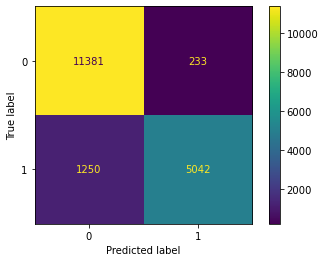

In [17]:
sink_model = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('tree', DecisionTreeClassifier(random_state=42, max_depth = 8))
])

sink_model.fit(x_train[used_num_cols], y_train)

displayMetrics(sink_model, x_train[used_num_cols], x_test[used_num_cols], y_train, y_test)

In [ ]:
sink_model = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('tree', DecisionTreeClassifier(random_state=42))
])

# sink_model.fit(x_train[used_num_cols], y_train)

param_grid = {
    'tree__criterion': ['gini','entropy'],
    'tree__max_depth': [None,5,6,7,8,9,10,25],
    'tree__min_samples_split': [5,10,25,50,100]
}

gridSearch = GridSearchCV(estimator=sink_model, param_grid=param_grid, verbose=1, cv=5, n_jobs=-1)

gridSearch.fit(x_train[used_num_cols], y_train)

gridTree = gridSearch.best_estimator_

gridSearch.best_params_

In [ ]:
train_preds = gridTree.predict(x_train[used_num_cols])
test_preds = gridTree.predict(x_test[used_num_cols])
train_probs = gridTree.predict_proba(x_train[used_num_cols])[:,1]
test_probs = gridTree.predict_proba(x_test[used_num_cols])[:,1]

train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)
train_recall = recall_score(y_train, train_preds, zero_division=0)
test_recall = recall_score(y_test, test_preds, zero_division=0)
train_precision = precision_score(y_train, train_preds, zero_division=0)
test_precision = precision_score(y_test, test_preds, zero_division=0)
train_f1 = f1_score(y_train, train_preds, zero_division=0)
test_f1 = f1_score(y_test, test_preds, zero_division=0)
train_rocauc = roc_auc_score(y_train, train_probs)
test_rocauc = roc_auc_score(y_test, test_probs)

print(F'\nTrain Accuracy:\t\t{train_accuracy}')
print(F'Test Accuracy:\t\t{test_accuracy}')
print(F"\nTrain Recall:\t\t{train_recall}")
print(F'Test Recall:\t\t{test_recall}')
print(F"\nTrain Precision:\t{train_precision}")
print(F'Test Precision:\t\t{test_precision}')
print(F"\nTrain f1:\t\t{train_f1}")
print(F'Test f1:\t\t{test_f1}')
print(F"\nTrain ROC-AUC:\t\t{train_rocauc}")
print(F'Test ROC-AUC:\t\t{test_rocauc}')

plot_confusion_matrix(gridTree, x_test, y_test)